In [1]:
# default_exp datasource

In [19]:
# export
import pandas as pd
import numpy as np
import requests
import json
import os
from datetime import datetime

In [17]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行
import matplotlib.pyplot as plt
%matplotlib inline
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# stock_dict

In [48]:
# export
stock_dict = {
    # 
    '大盘': 'sh000001',
    '上证50': 'sh510050',
    '沪深300': 'sh510300',
    '军工ETF': 'sh512660',
    '证券ETF': 'sh512880',
    '银行ETF': 'sh512800',
    '环保ETF': 'sh512580',
    '医药ETF': 'sh512010',
    '红利ETF': 'sh510880',
    '消费ETF': 'sh510150',
    '传媒ETF': 'sh512980',
    '科技ETF': 'sh515000',
    '半导体': 'sh512480',
    '信息技术ETF': 'sz159939',
    '通信ETF': 'sh515880',
    '国债ETF': 'sZ511010',
    '黄金ETF': 'sh518880',
    '500ETF': 'sh510500',
    '创业板ETF': 'sz159915',
}

In [9]:
# export
class DataSource(object):
    def __init__(self, code, startDate=None, endDate=None, dataLen=None, verbose=True, plot=False, keepRowData=False):
        """

        :keepRowData: bool. 是否保留self._rawData
        """
        if code in stock_dict:
            code = stock_dict[code]
        self._rawData = self.fetch(
            code, startDate, endDate, dataLen, verbose)  # 直接得到的未经处理原始数据
        if keepRowData:
            data = self._rawData.copy()
        else:
            data = self._rawData
        self.data = self.transform(data)  # 标准数据

    def fetch(self, code, startDate=None, endDate=None, dataLen=None):
        """
        从数据源获取数据，需要子类重新实现
        """
        return pd.DataFrame()

    def transform(self, raw_data):
        """
        把fetch到的原始数据转换为标准数据，需要子类重新实现
        """
        return pd.DataFrame()

## SinaDataSource

In [60]:
# export
class SinaDataSource(DataSource):
    def fetch(self, code, startDate=None, endDate=None, dataLen=None, verbose=False, plot=False):
        
        return get_hist_k_data(code, startDate, endDate, dataLen, verbose, plot)
    def transform(self, raw_data):
        _tmp = raw_data
        _tmp['t'] = _tmp.close.shift(1)
        _tmp['close_pct'] =(_tmp.close / _tmp.t - 1).map(lambda x: round(x, 3), na_action='ignore')
        _tmp['close_pct_log'] =(_tmp.close / _tmp.t).map(lambda x: round(np.log(x), 3), na_action='ignore')
        
        # 振幅
        _tmp['振幅'] = ((_tmp.high - _tmp.low) / _tmp.t).map(lambda x: round(x, 3), na_action='ignore')
        _tmp.loc[_tmp.close_pct < 0, '振幅'] =  _tmp.loc[_tmp.close_pct < 0, '振幅'] * (-1)
        
        _tmp['t'] = _tmp.volume.shift(1)
        _tmp['volume_pct'] =(_tmp.volume / _tmp.t - 1).map(lambda x: round(x, 3), na_action='ignore')
        _tmp['volume_pct_log'] =(_tmp.volume / _tmp.t).map(lambda x: round(np.log(x), 3), na_action='ignore')
        
        # 均线
        for d in [5, 10, 20, 60]:
            for c in 'close volume'.split():
                _tmp[f'{c}_ma{d}'] = _tmp[c].rolling(d).mean()
                # 当前值偏离均值的程度
                _tmp[f'{c}_ma{d}_diff_pct'] = ((_tmp[c] - _tmp[f'{c}_ma{d}'])/_tmp[f'{c}_ma{d}']).map(lambda x: round(x, 3), na_action='ignore')
                # 均值的斜率
                _tmp['t1'] = _tmp[f'{c}_ma{d}'].shift(1)
                _tmp['t2'] = _tmp[f'{c}_ma{d}'].shift(2)
                _tmp[f'{c}_ma{d}_grad1'] = _tmp[f'{c}_ma{d}']/_tmp['t1']
                _tmp[f'{c}_ma{d}_grad2'] = _tmp[f'{c}_ma{d}']/_tmp['t2']
                _tmp[f'{c}_ma{d}_grad12_diff'] = _tmp[f'{c}_ma{d}_grad1'] - _tmp[f'{c}_ma{d}_grad2']
                
                # 累计涨幅
                _tmp[f'{c}_pct_log_sum{d}'] = _tmp[f'{c}_pct_log'].rolling(d).sum()
        del _tmp['t'], _tmp['t1'], _tmp['t2']
        return _tmp

## get_hist_k_data(code, datalen)
获取最近datalen天的code的行情数据

In [25]:
(pd.to_datetime('2020-11-10') - pd.to_datetime('20001010')).days

7336

In [26]:
(datetime.now() - pd.to_datetime('20001010')).days

7221

In [39]:
(datetime.now() - pd.to_datetime('20001010'))

Timedelta('7221 days 07:54:32.166605')

In [52]:
end_date = pd.to_datetime('20001010')

In [54]:
end_date.strftime('%Y%m%d')

'20001010'

In [46]:
# export
def get_hist_k_data(code, start_date=None, end_date=None, datalen=None, verbose=False, plot=False):
    """
    
    """
    if end_date:
        end_date = pd.to_datetime(end_date)
    else:
        end_date = datetime.now()
    if start_date:
        datalen = (end_date - pd.to_datetime(start_date)).days
        print(datalen)
    if datalen is None: 
        return None
    print(f'code:{code}, start_date: {start_date}, end_date: {end_date.strftime("%Y%m%d")}, datalen: {datalen}')
    r = requests.get('http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/'
                     +'CN_MarketData.getKLineData?symbol={}&scale=240&ma=no&datalen={}'.format(code, datalen))
    rs = r.text
    cols_num = ['open', 'high', 'low', 'close', 'volume']
    cols = ['day'] + cols_num
    df1 = pd.DataFrame(json.loads(rs))
    df1.loc[:, cols_num] = df1.loc[:, cols_num].applymap(float)
    df1.loc[:, 'day'] = pd.to_datetime(df1.day)
    df1 = df1[(start_date<=df1.day)&(df1.day<=end_date)]
    df1.set_index('day', inplace=True)
    if verbose:
        print(df1.head(2))
        print(df1.tail(2))
    if plot:
        df1.close.plot()
        
    return df1

870
               open     high      low    close       volume
day                                                        
2018-03-01  3235.09  3280.15  3228.59  3273.76  15909832000
2018-03-02  3248.45  3269.94  3242.27  3254.53  15086106300
               open     high      low    close       volume
day                                                        
2020-07-16  3356.36  3373.53  3209.73   3210.1  49061312300
2020-07-17   3214.4  3252.78  3181.28  3214.13  35965241300


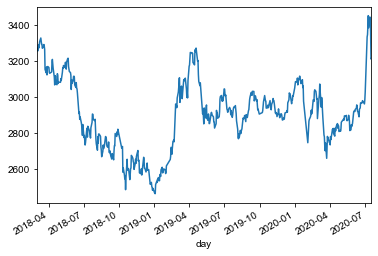

In [49]:
df = get_hist_k_data(stock_dict['大盘'], start_date='20180301', verbose=True, plot=True)

870
            open   high    low  close     volume
day                                             
2018-03-01     4  4.067  3.993  4.049  118636949
2018-03-02  4.02  4.043  4.008  4.022   90614682
            open   high    low  close      volume
day                                              
2020-07-16  4.79  4.828   4.55  4.556  1289918063
2020-07-17  4.57  4.654  4.541  4.605   904292349


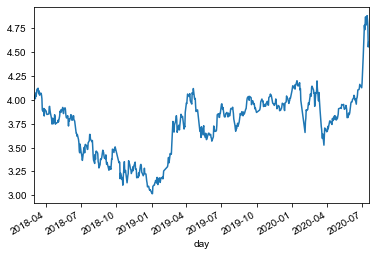

In [47]:
df = get_hist_k_data('sh510300', start_date='20180301', verbose=True, plot=True)

                  day   open   high    low  close     volume
day                                                         
2018-06-28 2018-06-28   3.45  3.499   3.44  3.446  162531044
2018-06-29 2018-06-29  3.449  3.543  3.449  3.537  170604955
                  day  open   high    low  close      volume
day                                                         
2020-07-16 2020-07-16  4.79  4.828   4.55  4.556  1289918063
2020-07-17 2020-07-17  4.57  4.654  4.541  4.605   904292349


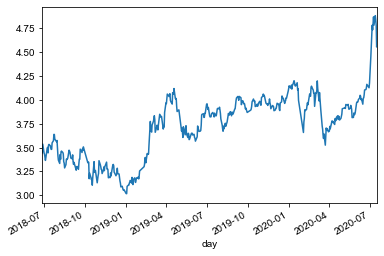

In [28]:
df = get_hist_k_data('sh510300', datalen=500, verbose=True, plot=True)

In [ ]:
model

# nbexport

In [76]:
from nbdev.export import *
notebook2script('0datasource.ipynb')

Converted 0datasource.ipynb.
